In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
df = pd.read_excel('数据集.xlsx')  # 确保文件名正确，放在当前工作目录

# 划分特征与标签
X = df.drop('Y', axis=1)   # ✅ 保留原始列名
y = df['Y']

# 划分训练集、验证集、测试集（8:1:1）
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)  # 0.125 x 0.8 = 0.1

# 开始模型调参
import optuna
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# XGBoost 模型的优化目标函数
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100, 200, 300]),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_uniform('gamma', 0, 5)
    }

    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)

# 随机森林模型的优化目标函数
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100, 200, 300]),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return mean_squared_error(y_val, y_pred)

# 优化 XGBoost 模型
study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=100)
print("✅ Best parameters for XGBoost:", study_xgb.best_params)

# 训练最佳 XGBoost 模型
best_xgb_model = XGBRegressor(**study_xgb.best_params, random_state=42)
best_xgb_model.fit(X_train, y_train)

# 优化随机森林模型
study_rf = optuna.create_study(direction="minimize")
study_rf.optimize(objective_rf, n_trials=100)
print("✅ Best parameters for RandomForest:", study_rf.best_params)

# 训练最佳随机森林模型
best_rf_model = RandomForestRegressor(**study_rf.best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_rf = best_rf_model.predict(X_test)

# 计算误差与R2
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_xgb = r2_score(y_test, y_pred_xgb)
r2_rf = r2_score(y_test, y_pred_rf)

# 计算 MAE 和 RMSE
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_xgb = mse_xgb**0.5  # RMSE 是 MSE 的平方根
rmse_rf = mse_rf**0.5


# 打印所有指标
print(f"🎯 XGBoost - MSE: {mse_xgb:.4f}, R2: {r2_xgb:.4f}, MAE: {mae_xgb:.4f}, RMSE: {rmse_xgb:.4f}, ")
print(f"🎯 RandomForest - MSE: {mse_rf:.4f}, R2: {r2_rf:.4f}, MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}, ")



[I 2025-04-22 10:31:15,050] A new study created in memory with name: no-name-3dc80aa6-10c2-40ed-92b6-81bd3eb1613d
[I 2025-04-22 10:31:15,219] Trial 0 finished with value: 45.41221919598024 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.19929062586754617, 'subsample': 0.9522434782746796, 'colsample_bytree': 0.6736973627945628, 'gamma': 4.157475092514559}. Best is trial 0 with value: 45.41221919598024.
[I 2025-04-22 10:31:15,302] Trial 1 finished with value: 53.598075227516254 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.0830665213702817, 'subsample': 0.6068955099218041, 'colsample_bytree': 0.5782853581635408, 'gamma': 2.398184790409897}. Best is trial 0 with value: 45.41221919598024.
[I 2025-04-22 10:31:15,368] Trial 2 finished with value: 67.5787219246017 and parameters: {'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.017795323447891268, 'subsample': 0.7824923898240694, 'colsample_bytree': 0.6443333126577536, 'gamma': 4.7

✅ Best parameters for XGBoost: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.06262670003925316, 'subsample': 0.9980533967575388, 'colsample_bytree': 0.9710306247443513, 'gamma': 2.199899957328664}


[I 2025-04-22 10:31:27,887] Trial 1 finished with value: 97.74542245239262 and parameters: {'n_estimators': 200, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 1 with value: 97.74542245239262.
[I 2025-04-22 10:31:28,024] Trial 2 finished with value: 37.394660636357806 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 2 with value: 37.394660636357806.
[I 2025-04-22 10:31:28,220] Trial 3 finished with value: 29.330304104260115 and parameters: {'n_estimators': 300, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 4, 'bootstrap': True}. Best is trial 3 with value: 29.330304104260115.
[I 2025-04-22 10:31:28,248] Trial 4 finished with value: 116.9116536434719 and parameters: {'n_estimators': 50, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 20, 'bootstrap': False}. Best is trial 3 with value: 29.330304104260115.
[I 2025-04-22 10:

✅ Best parameters for RandomForest: {'n_estimators': 300, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}
🎯 XGBoost - MSE: 201.8086, R2: 0.7642, MAE: 6.9800, RMSE: 14.2059, 
🎯 RandomForest - MSE: 214.4161, R2: 0.7494, MAE: 7.3299, RMSE: 14.6430, 


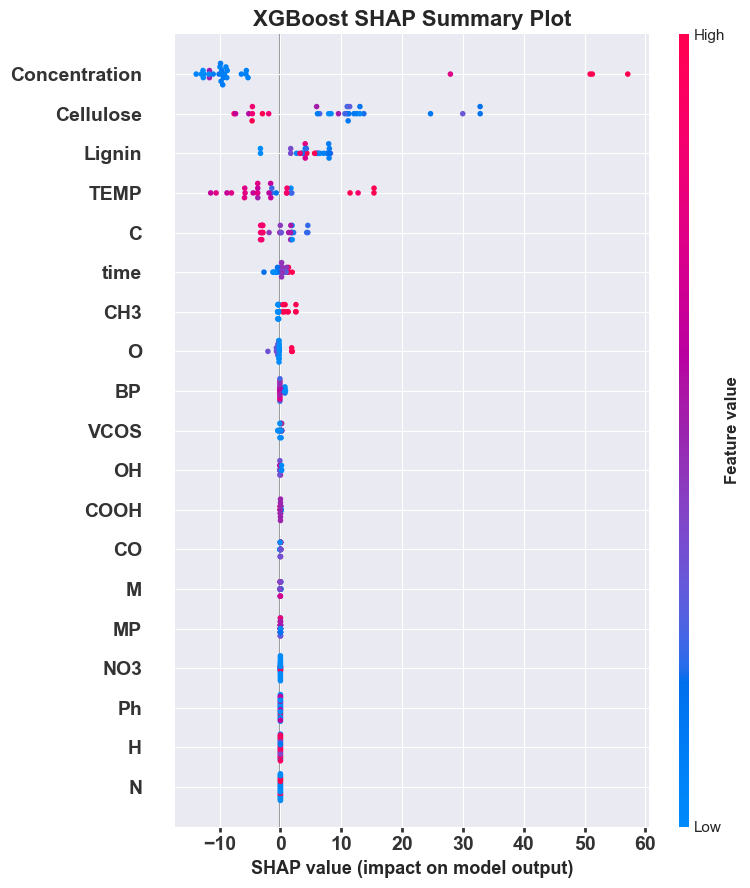

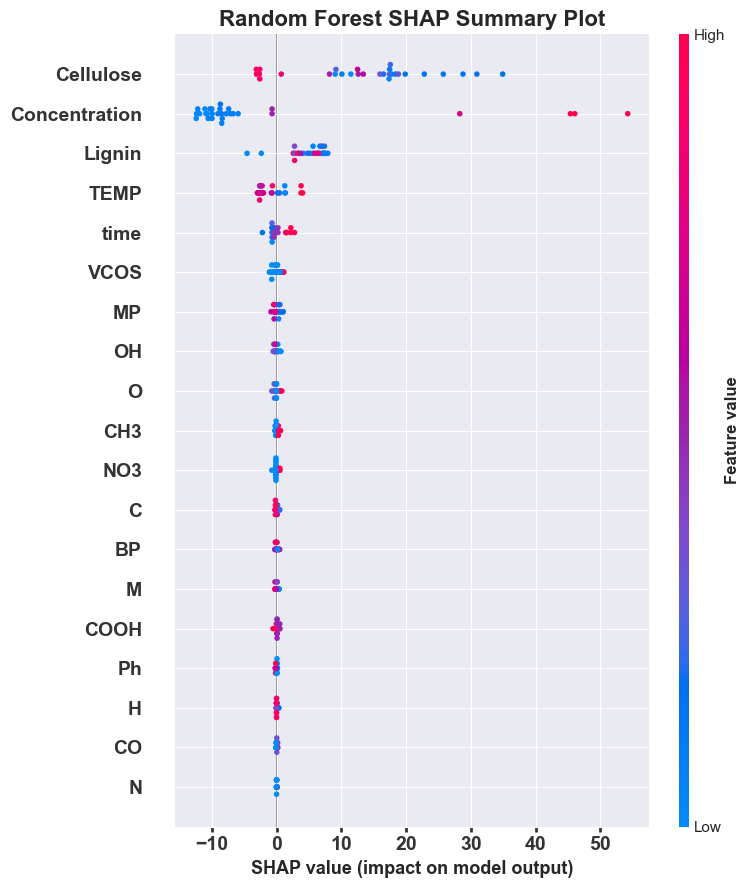

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib  # 用于加载模型
from matplotlib import rcParams
from sklearn.model_selection import train_test_split

# 设置全局字体为 Arial，字体大小为 14，并且加粗
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 14
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

# ===== Step 1: 加载数据 =====
# 替换为你的数据路径
# 例如：df = pd.read_excel('your_data.xlsx')
df = pd.read_excel("数据集.xlsx")

X = df.drop(['Y'], axis=1)
y = df['Y']

# 划分训练集和测试集（需与训练时保持一致 random_state）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===== Step 2: 加载已保存模型 =====
xgb_model = joblib.load("xgb_3model.pkl")
rf_model = joblib.load("rf_3model.pkl")

# ===== Step 3: 创建 SHAP 解释器 =====
xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(X_test)

rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer.shap_values(X_test)

# ===== Step 4: XGBoost SHAP summary plot =====
plt.figure(figsize=(10, 6))
shap.summary_plot(xgb_shap_values, X_test, plot_type="dot", show=False)
plt.title('XGBoost SHAP Summary Plot', fontsize=16, fontweight='bold')

plt.gca().tick_params(axis='both', which='major', labelsize=14, width=2)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontname('Arial')
    label.set_fontweight('bold')
plt.tight_layout()
plt.savefig("678.pdf", format='pdf', bbox_inches='tight')
plt.show()

# ===== Step 5: Random Forest SHAP summary plot =====
plt.figure(figsize=(10, 6))
shap.summary_plot(rf_shap_values, X_test, plot_type="dot", show=False)
plt.title('Random Forest SHAP Summary Plot', fontsize=16, fontweight='bold')

plt.gca().tick_params(axis='both', which='major', labelsize=14, width=2)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontname('Arial')
    label.set_fontweight('bold')
plt.tight_layout()
plt.savefig("454.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [3]:
def plot_feature_importance_horizontal(model, feature_names, model_name="Model"):
    importances = model.feature_importances_
    indices = np.argsort(importances)  # 这里不需要反转，y轴从下往上排

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(importances)), importances[indices], align="center", color='skyblue')
    plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
    plt.xlabel('Importance', fontsize=14, fontweight='bold')
    plt.title(f'{model_name} Feature Importance', fontsize=16, fontweight='bold')

    # 设置字体加粗
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=14, width=2)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Arial')
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.show()


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(model, X_train, feature_names, top_n=10):
    """
    绘制特征重要性图

    参数：
    - model: 已经训练好的模型，支持 feature_importances_ 属性（例如：RandomForest、XGBoost 等）。
    - X_train: 训练集特征数据。
    - feature_names: 特征名列表。
    - top_n: 要显示的最重要的前n个特征。
    """
    # 获取特征重要性
    feature_importances = model.feature_importances_

    # 将特征和其重要性值组合在一起
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # 按照特征重要性排序
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # 获取前 top_n 个特征
    top_features = feature_importance_df.head(top_n)

    # 绘制条形图
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Important Features')
    plt.gca().invert_yaxis()  # 反转y轴，使得重要性高的特征在上面
    plt.show()


In [5]:
import joblib

# 保存XGBoost模型
joblib.dump(best_xgb_model, 'xgb_model.pkl')

# 保存随机森林模型
joblib.dump(best_rf_model, 'rf_model.pkl')

print("模型保存成功！")


模型保存成功！


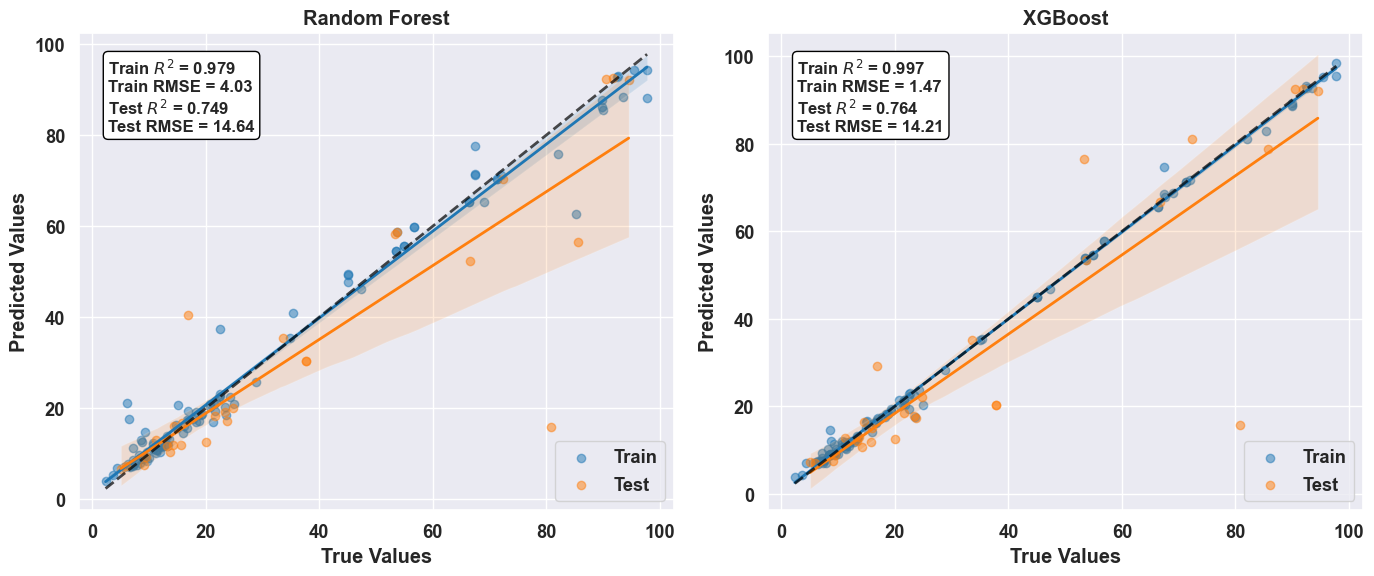

In [9]:
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# 加载数据
df = pd.read_excel("数据集.xlsx")  # 读取 Excel 文件
X = df.drop(columns=['Y'])  # 特征数据
y = df['Y']  # 目标标签

# 设置全局字体为 Arial 并加粗
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
sns.set_context("notebook", font_scale=1.2, rc={"font.weight": 'bold'})
# 加载训练好的模型
rf_model = joblib.load('rf_model.pkl')  # 加载 Random Forest 模型
xgb_model = joblib.load('xgb_model.pkl')  # 加载 XGBoost 模型

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义辅助函数，用于获取预测结果和评价指标
def get_model_predictions(model, model_name, X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    return y_pred_train, y_pred_test, r2_train, r2_test, rmse_train, rmse_test

# 获取预测结果和评价指标
y_pred_rf_train, y_pred_rf_test, r2_rf_train, r2_rf_test, rmse_rf_train, rmse_rf_test = get_model_predictions(
    rf_model, 'Random Forest', X_train, X_test, y_train, y_test)

y_pred_xgb_train, y_pred_xgb_test, r2_xgb_train, r2_xgb_test, rmse_xgb_train, rmse_xgb_test = get_model_predictions(
    xgb_model, 'XGBoost', X_train, X_test, y_train, y_test)

# 创建两个子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # 1行2列

# 绘制 Random Forest 的图
ax1.scatter(y_train, y_pred_rf_train, color='#1f77b4', alpha=0.5, label="Train")
ax1.scatter(y_test, y_pred_rf_test, color='#ff7f0e', alpha=0.5, label="Test")
sns.regplot(x=y_train, y=y_pred_rf_train, scatter=False, line_kws={'linewidth': 2}, ax=ax1)
sns.regplot(x=y_test, y=y_pred_rf_test, scatter=False, line_kws={'linewidth': 2}, ax=ax1)

ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', linewidth=2, alpha=0.7)  # x=y 参考线
ax1.text(0.05, 0.95, f"Train $R^2$ = {r2_rf_train:.3f}\nTrain RMSE = {rmse_rf_train:.2f}\n"
                    f"Test $R^2$ = {r2_rf_test:.3f}\nTest RMSE = {rmse_rf_test:.2f}",
            transform=ax1.transAxes, fontsize=12, fontweight='bold', verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", edgecolor="black"))

ax1.set_title('Random Forest')
ax1.set_xlabel('True Values')
ax1.set_ylabel('Predicted Values')
ax1.legend()

# 绘制 XGBoost 的图
ax2.scatter(y_train, y_pred_xgb_train, color='#1f77b4', alpha=0.5, label="Train")
ax2.scatter(y_test, y_pred_xgb_test, color='#ff7f0e', alpha=0.5, label="Test")
sns.regplot(x=y_train, y=y_pred_xgb_train, scatter=False, line_kws={'linewidth': 2}, ax=ax2)
sns.regplot(x=y_test, y=y_pred_xgb_test, scatter=False, line_kws={'linewidth': 2}, ax=ax2)

ax2.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', linewidth=2, alpha=0.7)  # x=y 参考线
ax2.text(0.05, 0.95, f"Train $R^2$ = {r2_xgb_train:.3f}\nTrain RMSE = {rmse_xgb_train:.2f}\n"
                    f"Test $R^2$ = {r2_xgb_test:.3f}\nTest RMSE = {rmse_xgb_test:.2f}",
            transform=ax2.transAxes, fontsize=12, fontweight='bold', verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", edgecolor="black"))

ax2.set_title('XGBoost')
ax2.set_xlabel('True Values')
ax2.set_ylabel('Predicted Values')
ax2.legend()

# 调整布局，避免重叠
plt.tight_layout()

# 保存和展示
plt.savefig("True_vs_Predicted_Comparison_RF_XGB.pdf", format='pdf', bbox_inches='tight')
plt.show()


2025-04-21 17:19:34.242 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-21 17:19:34.574 
  command:

    streamlit run C:\Users\79971\miniconda3\envs\test_env_1\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-04-21 17:19:34.575 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-21 17:19:34.575 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-21 17:19:34.576 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-21 17:19:34.576 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-21 17:19:34.576 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-21 17:19:34.577 Thread

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Feature 1
- Feature 2
Feature names seen at fit time, yet now missing:
- BP
- C
- CH3
- CO
- COOH
- ...
